In [9]:
# First we grab the model and the unembedding weight matrix
import torch
from easy_transformer import EasyTransformer

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

# Convenience function for decoding token
decode = model.tokenizer.decode
encode = model.tokenizer.encode

M_to_V = model.unembed.W_U.data
d_M = model.cfg.d_model
d_V = model.cfg.d_vocab

Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [35]:
from sklearn.decomposition import PCA

V_to_M = torch.nn.functional.normalize(torch.linalg.pinv(M_to_V), dim=1)

pca_model = PCA(n_components=d_M)
M_to_D = torch.tensor(pca_model.fit_transform(M_to_V), dtype=torch.float)
D_to_V = torch.tensor(pca_model.components_, dtype=torch.float)

norms = torch.linalg.vector_norm(M_to_D, dim=0)
#M_to_D = M_to_D / norms.reshape(1, d_D).expand(d_M, d_D)
#D_to_V = D_to_V * norms.reshape(d_D, 1).expand(d_D, d_V)

#print(M_to_V)
#print(torch.matmul(M_to_D, D_to_V))


V_to_D = torch.matmul(V_to_M, M_to_D)
d_D = d_M

print(V_to_M.shape, M_to_D.shape, D_to_V.shape, M_to_V.shape, V_to_D.shape)

torch.Size([50257, 768]) torch.Size([768, 768]) torch.Size([768, 50257]) torch.Size([768, 50257]) torch.Size([50257, 768])


In [82]:
example_tokens = [' cat', ' war', ' banana', ' bat', ' bark', ' leaves']

def print_similar(heading, td):
    print(heading, torch.linalg.vector_norm(td).item())
    similarity_vec = torch.matmul(V_to_D, td)
    values = [(v.item(), i) for i,v in enumerate(similarity_vec)]
    values.sort(reverse=True)
    for v,i in values[:20]:
        print(f'  {decode(i):20}', f'{v:20}')
    print()

for tok in example_tokens:
    t, = encode(tok)
    td = V_to_D[t,:]
    print_similar(tok, td)

 cat 25.196977615356445
   cat                       634.8876953125
   cats                  404.85211181640625
   Cat                        401.826171875
  Cat                    327.85736083984375
  cat                     311.1290283203125
   Cats                   273.6062316894531
   dog                   254.74285888671875
   CAT                      220.56103515625
  cats                   218.95774841308594
   catcher                 211.718994140625
   kittens               210.29351806640625
   kitten                202.44485473632812
   dogs                  166.30856323242188
   animal                 162.6132049560547
   pet                   160.79998779296875
   goat                    159.751220703125
   Dog                   155.82252502441406
   rabbit                155.04403686523438
   tiger                  149.2018280029297
   fel                   142.49505615234375

 war 23.992053985595703
   war                      575.61865234375
   War                   42

In [57]:
def subtract_meaning(v0, tok):
    t1, = encode(tok)
    v1 = V_to_D[t1,:]
    similarity0 = torch.matmul(V_to_D, v0)
    similarity1 = torch.matmul(V_to_D, v1)
    ratio = similarity0[t1] / similarity1[t1]
    return v0 - ratio * v1

start_tok = ' leaves'
minus_toks = [' leaf', ' stems']
t0, = encode(start_tok)
v0 = V_to_D[t0,:]
heading = start_tok
for minus_tok in minus_toks:
    v0 = subtract_meaning(v0, minus_tok)
    heading += f' - {minus_tok}'
print_similar(heading, v0)

 leaves -  leaf -  stems
   leaves                  473.925048828125
   leave                   324.559814453125
   leaving                  268.76904296875
   Leaves                 257.9458923339844
   left                  237.17068481445312
   Leaving               174.34120178222656
   depart                167.43597412109375
   gives                 149.91940307617188
   departed               135.7659912109375
  leave                       132.298828125
   begs                  130.66094970703125
  left                   127.87675476074219
  Left                    127.3669662475586
   puts                  125.24998474121094
   makes                 122.95455169677734
   paints                119.03379821777344
  Leave                  117.99737548828125
   departure             117.94159698486328
   Leave                 116.73554992675781
   brings                116.35395812988281



In [62]:
start_tok = ' leaves'
minus_toks = [' leave', ' begs', ' drops', ' left']
t0, = encode(start_tok)
v0 = V_to_D[t0,:]
heading = start_tok
for minus_tok in minus_toks:
    v0 = subtract_meaning(v0, minus_tok)
    heading += f' - {minus_tok}'
print_similar(heading, v0)

 leaves -  leave -  begs -  drops -  left
   leaves                347.57379150390625
   Leaves                 219.2523193359375
   leaf                  179.02911376953125
   foliage               166.76878356933594
   plants                150.98391723632812
   stems                  132.1868896484375
   Leaf                  125.02388000488281
   flowers               114.13780975341797
   bloss                  106.9514389038086
   trees                  102.3676528930664
   shoots                100.98654174804688
   shapes                 99.13948822021484
   crosses                97.99234008789062
   logs                   95.91049194335938
   limbs                  95.73692321777344
   bark                   93.61419677734375
   branches               92.32135009765625
   flies                  92.00608825683594
   poses                  88.89459991455078
   sap                    88.85250854492188



In [85]:
start_tok = ' leaves'
minus_toks = [' Leaves', ' leave', ' begs', ' plants', ' leaf', ' left']
t0, = encode(start_tok)
v0 = V_to_D[t0,:]
heading = start_tok
for minus_tok in minus_toks:
    v0 = subtract_meaning(v0, minus_tok)
    heading += f' - {minus_tok}'
print_similar(heading, 1.5 * v0)

 leaves -  Leaves -  leave -  begs -  plants -  leaf -  left 25.921682357788086
   leaves                322.94158935546875
   crosses               134.72967529296875
   reduces               126.36771392822266
   bears                 123.02333068847656
   shapes                121.09452819824219
   wounds                117.23699951171875
   carries               115.47770690917969
   brings                110.84492492675781
   acknowledges          110.80630493164062
   hides                 109.40266418457031
   stems                 109.34490966796875
   fails                 108.09822082519531
   presents              104.26521301269531
   mesh                  104.23077392578125
   prevents                103.551513671875
   kills                 102.25137329101562
   reflects              101.93321228027344
  tab                     99.77706909179688
   holds                  99.55914306640625
   solves                 98.12925720214844



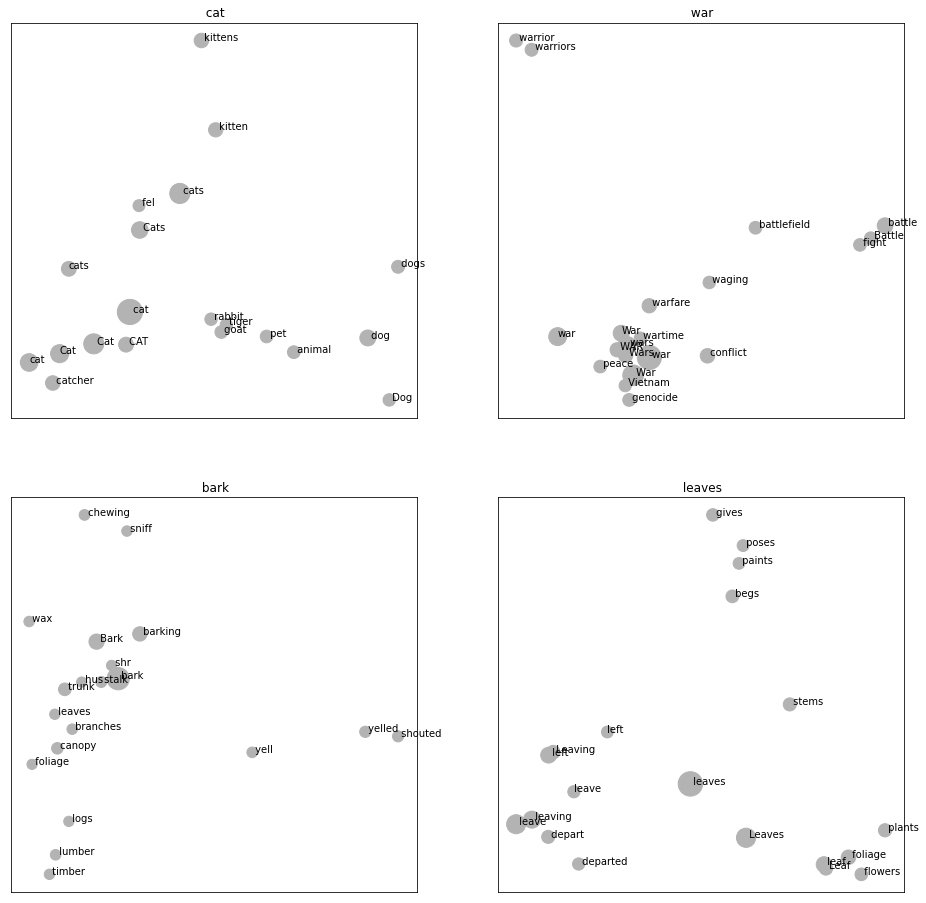

In [186]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import math

plt.rcParams['figure.figsize'] = [16, 16]

toks = [' cat', ' war', ' bark', ' leaves']

def plot_similar_words(ax, heading, td, n=20):
    similarity_vec = torch.matmul(V_to_D, td)
    values = [(v.item(), i) for i,v in enumerate(similarity_vec)]
    values.sort(reverse=True)
    
    adj_vecs = torch.zeros((n, d_D))
    sizes = np.zeros((n,))
    text = []
    for i in range(n):
        adj_vecs[i] = V_to_D[values[i][1],:]
        sizes[i] = max(0, values[i][0])
        text.append(decode(values[i][1]))
    dot_products = torch.matmul(adj_vecs, adj_vecs.T)
    X = adj_vecs #torch.nn.functional.normalize(adj_vecs, dim=1)
    
    pca = PCA(n_components = 2)
    xy = pca.fit_transform(X)
    ax.scatter(xy[:,0], xy[:,1], s=sizes, color=(0.7,0.7,0.7))
    for i in range(n):
        ax.annotate(text[i], (xy[i,0], xy[i,1]))
    ax.set_title(heading)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig, ax = plt.subplots(2,2)
for i in range(4):
    t0, = encode(toks[i])
    v0 = V_to_D[t0,:]
    plot_similar_words(ax[i // 2][i % 2], toks[i], v0, n=20)

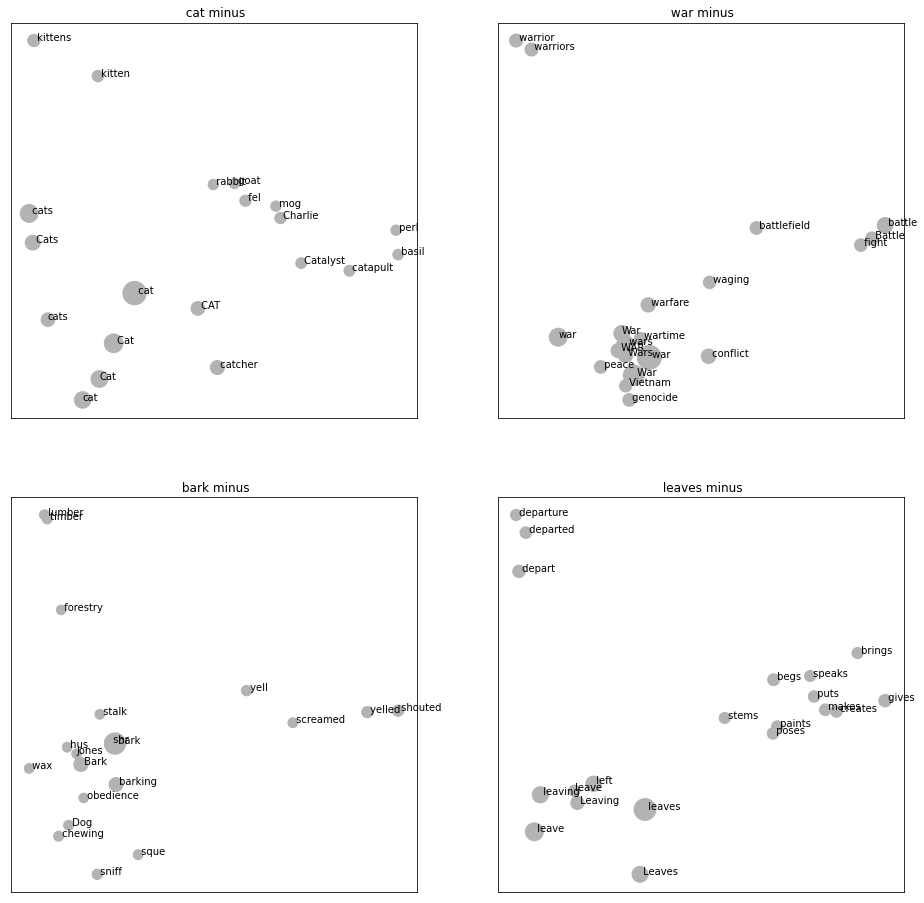

In [187]:
minuses = [
    [' cat', ' dog'],
    [' war'],
    [' bark', ' trunk', ' leaves'],
    [' leaves', ' leaf', ' foliage'],
]
fig, ax = plt.subplots(2,2)
for i in range(4):
    t0, = encode(minuses[i][0])
    v = V_to_D[t0,:]
    for tok in minuses[i][1:]:
        v = subtract_meaning(v, tok)
    plot_similar_words(ax[i // 2][i % 2], f'{minuses[i][0]} minus', v, n=20)